In [205]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Tasks
1. \+ Get year, get country, get aggregated series and real series
2. \+ Plot series if needed
3. \+ HFD method
4. \+ CS method
5. \+ QO method
6. NN method
7. \+ Get error of approximation
8. \+ Compare with other methods

### Retrieve data

In [2]:
df_all = pd.read_csv('HFD_data.csv')
df_agg = pd.read_csv('HFD_aggregated.csv')

In [3]:
def get_Fx(country_code, year):
    _df_all = df_all[(df_all['Code'] == country_code) & (df_all['Year'] == year)]
    _df_agg = df_agg[(df_agg['Code'] == country_code) & (df_agg['Year'] == year)]
    
    _1Fx = pd.Series(_df_all['ASFR'].values, index=_df_all['Age'])
    _5Fx = pd.Series(_df_agg['ASFR'].values, index=_df_agg['Age'])

    return _1Fx, _5Fx

In [6]:
_1Fx, _5Fx = get_Fx('RUS', 1985)

In [7]:
_1Fx.head()

Age
12    2.912385e-07
13    9.833045e-06
14    1.788173e-04
15    1.512733e-03
16    8.736664e-03
dtype: float64

In [8]:
_5Fx

Age
10    0.000061
15    0.047274
20    0.165326
25    0.112414
30    0.059696
35    0.023305
40    0.003614
45    0.000279
50    0.000012
dtype: float64

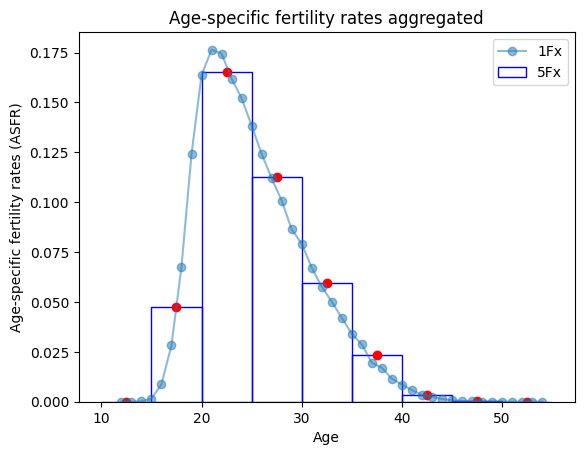

In [9]:
bars = plt.bar(_5Fx.index, _5Fx, align='edge', width=5, color='none', edgecolor='blue', linewidth=1, label='5Fx')
for bar in bars:
    height = bar.get_height()
    plt.plot(bar.get_x() + bar.get_width() / 2, height, 'ro')
    
plt.plot(_1Fx.index, _1Fx, '-o', alpha=0.5, label='1Fx')
plt.xlabel('Age')
plt.ylabel('Age-specific fertility rates (ASFR)')
plt.title('Age-specific fertility rates aggregated')
plt.legend();

### HFD's splitting protocol

In [10]:
from scipy.interpolate import PchipInterpolator

In [11]:
def HFD(_5Fx):

    F = 5 * _5Fx.cumsum()
    Y = np.log(F / (F.iloc[-1] - F))
    Y.index = Y.index + 5
    
    Y[10] = -20
    Y[55] = 12
    Y = Y.sort_index()

    pchip = PchipInterpolator(Y.index, Y)
    Y_hat = pd.Series(pchip(range(10, 56)), index=range(10, 56))

    F_hat = np.exp(Y_hat) / (1 + np.exp(Y_hat)) * F.iloc[-1]
    
    _1Fx_hat = pd.Series(np.diff(F_hat)[2:], index=range(12, 55))
    return _1Fx_hat

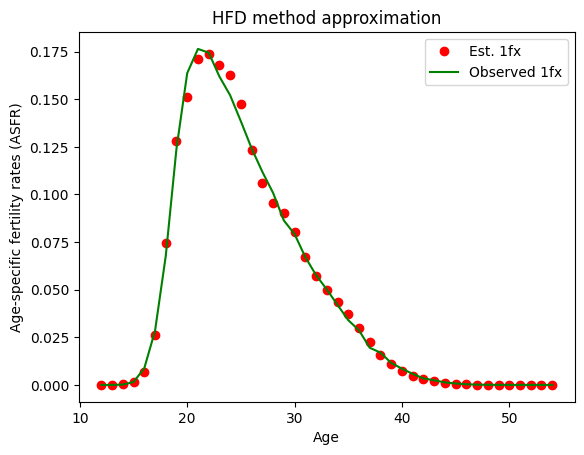

In [12]:
plt.plot(HFD(_5Fx), 'or')
_1Fx.plot(style='g')
plt.xlabel('Age')
plt.ylabel('Age-specific fertility rates (ASFR)')
plt.title('HFD method approximation')
plt.legend(['Est. 1fx', 'Observed 1fx']);

### Calibrated spline (CS) method

In [13]:
def CS(_5Fx):
    
    # https://calibrated-spline.schmert.net/data/K9.csv
    K9 = pd.read_csv('K9.csv')
    
    pred = K9.iloc[:, 1:].to_numpy() @ _5Fx.to_numpy()
    
    values = (pred[1:-1][::2] + pred[1:-1][1::2]) / 2
    values = np.insert(values, 0, pred[0])
    #values = np.append(values, pred[-1])

    _1Fx = pd.Series(values, index=range(12, 55))

    return _1Fx

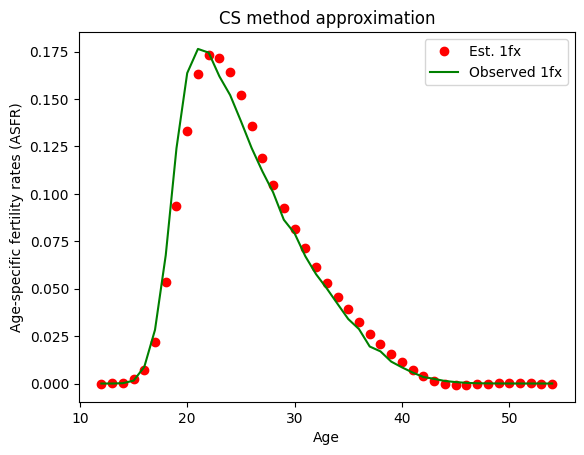

In [14]:
plt.plot(CS(_5Fx), 'or')
_1Fx.plot(style='g')
plt.xlabel('Age')
plt.ylabel('Age-specific fertility rates (ASFR)')
plt.title('CS method approximation')
plt.legend(['Est. 1fx', 'Observed 1fx']);

### Quadratic optimization (QO) method

In [15]:
from scipy.optimize import minimize

In [16]:
def QO(_5Fx):

    m = 43     # 54 - 12 + 1

    F = np.zeros((m, m))
    for i in range(m-2):
        for j in range(m):
            if i == j or i == j+2:
                F[j, i] = 1
            elif i == j+1:
                F[j, i] = -2

    G = np.zeros((9, m))
    G[0][:3] = 1/2
    for i in range(1, 9):
        G[i][5*(i-1)+4 : 5*i+4] = 1/5 

    result = minimize(
        lambda fr: np.linalg.norm(F @ fr)**2,
        x0=[0]*m,
        constraints=(
            {'type': 'eq', 'fun': lambda fr:  G @ fr - _5Fx}),
        bounds=[(0, None)] * m
    )

    _1Fx = pd.Series(result.x, index=range(12, 55))

    return _1Fx

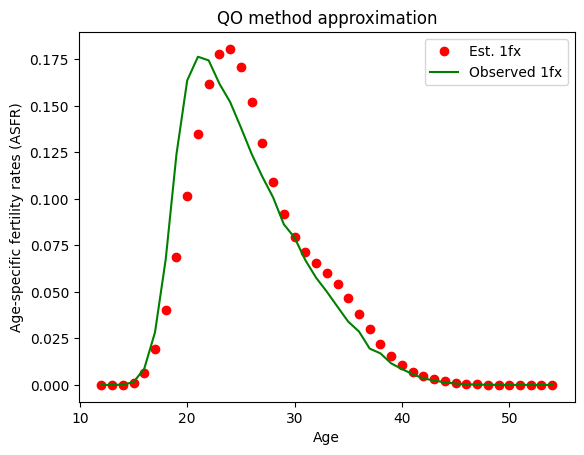

In [17]:
plt.plot(QO(_5Fx), 'or')
_1Fx.plot(style='g')
plt.xlabel('Age')
plt.ylabel('Age-specific fertility rates (ASFR)')
plt.title('QO method approximation')
plt.legend(['Est. 1fx', 'Observed 1fx']);

### Neural network (NN) method

### Models comparison

In [18]:
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

In [19]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [117]:
def get_predictions():

    m = 43
    
    result = np.array([None] * 7)
    
    for code in tqdm(df_all['Code'].unique()):
        for year in tqdm(df_all[df_all['Code'] == code]['Year'].unique()):

            df_1Fx = df_all[(df_all['Code'] == code) & (df_all['Year'] == year)][['Age', 'ASFR']]
            df_5Fx = df_agg[(df_agg['Code'] == code) & (df_agg['Year'] == year)][['Age', 'ASFR']]

            _1Fx = pd.Series(df_1Fx['ASFR'])
            _1Fx.index = df_1Fx['Age']
            _5Fx = pd.Series(df_5Fx['ASFR'])
            _5Fx.index = df_5Fx['Age']

            try:
                HFD_result = HFD(_5Fx)
            except:
                HFD_result = [np.nan] * 43
            try:
                CS_result = CS(_5Fx)
            except:
                CS_result = [np.nan] * 43
            try:
                QO_result = QO(_5Fx)
            except:
                QO_result = [np.nan] * 43

            result = np.vstack((result,
                np.array([[code]*m, [year]*m, range(12, 55), _1Fx, HFD_result, CS_result, QO_result]).T)
            )

    df = pd.DataFrame(result, columns=['Code', 'Year', 'Age', 'ASFR', 'HFD', 'CS', 'QO']).drop([0]).reset_index(drop=True)
    df['Year'] = df['Year'].astype('Int64')
    df['Age'] = df['Age'].astype('Int64')
    df['1Fx'] = df['1Fx'].astype('Float64')
    df['HFD'] = df['HFD'].astype('Float64')
    df['CS'] = df['CS'].astype('Float64')
    df['QO'] = df['QO'].astype('Float64')
    
    return df

In [ ]:
df_pred = get_predictions()

In [119]:
df_pred.head()

,Code,Year,Age,ASFR,HFD,CS,QO
0,AUT,1951,12,0.0,0.00001,0.0,0.000012
1,AUT,1951,13,0.0,0.000081,0.000197,0.000013
2,AUT,1951,14,0.000368,0.000443,0.001015,0.000188
3,AUT,1951,15,0.001499,0.00191,0.003401,0.002303
4,AUT,1951,16,0.008456,0.007411,0.008364,0.00738


In [120]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84581 entries, 0 to 84580
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Code    84581 non-null  object 
 1   Year    84581 non-null  Int64  
 2   Age     84581 non-null  Int64  
 3   ASFR    84581 non-null  Float64
 4   HFD     84581 non-null  Float64
 5   CS      84581 non-null  Float64
 6   QO      84581 non-null  Float64
dtypes: Float64(4), Int64(2), object(1)
memory usage: 5.0+ MB


In [115]:
def test_overall():

    # Code, Year, HFD, CS, QO, (NN)

    result = []

    for code in tqdm(df_pred['Code'].unique()):
        for year in tqdm(df_pred[df_pred['Code'] == code]['Year'].unique()):
            
            df_1Fx = df_pred[(df_pred['Code'] == code) & (df_pred['Year'] == year)]

            _1Fx = pd.Series(df_1Fx['ASFR'])
            _1Fx.index = df_1Fx['Age']
            
            pred_HFD = pd.Series(df_1Fx['HFD'])
            pred_HFD.index = df_1Fx['Age']

            pred_CS = pd.Series(df_1Fx['CS'])
            pred_CS.index = df_1Fx['Age']

            pred_QO = pd.Series(df_1Fx['QO'])
            pred_QO.index = df_1Fx['Age']
            
            if not np.isnan(pred_HFD).any():
                HFD_result = rmse(_1Fx, pred_HFD)
            else:
                HFD_result = np.nan
            
            if not np.isnan(pred_CS).any():
                CS_result = rmse(_1Fx, pred_CS)
            else:
                CS_result = np.nan
                
            if not np.isnan(pred_QO).any():
                QO_result = rmse(_1Fx, pred_QO)
            else:
                QO_result = np.nan
            
            result.append(
                [code, year, HFD_result, CS_result, QO_result]
            )

    return pd.DataFrame(result, columns=['Code', 'Year', 'HFD', 'CS', 'QO'])

In [116]:
results = test_overall()

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [89]:
results.head()

,Code,Year,HFD,CS,QO
0,AUT,1951,0.002536,0.005186,0.009987
1,AUT,1952,0.002512,0.005146,0.010140
2,AUT,1953,0.002495,0.005187,0.010646
3,AUT,1954,0.002779,0.005753,0.011273
4,AUT,1955,0.003675,0.007048,0.012916


In [90]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 0 to 1966
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Code    1967 non-null   object 
 1   Year    1967 non-null   int64  
 2   HFD     1381 non-null   float64
 3   CS      1967 non-null   float64
 4   QO      1967 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 77.0+ KB


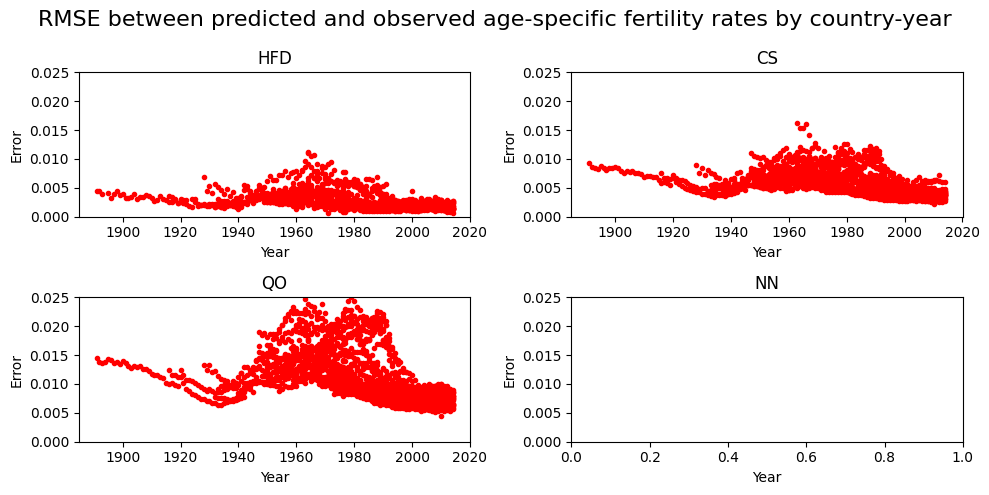

In [200]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

for i in range(2):
    for j in range(2):
        ax[i][j].set_ylim([0, 0.025])
        ax[i][j].set_xlabel('Year')
        ax[i][j].set_ylabel('Error')

ax[0][0].plot(results['Year'], results['HFD'], 'r.')
ax[0][0].set_title('HFD')
ax[0][1].plot(results['Year'], results['CS'], 'r.')
ax[0][1].set_title('CS')
ax[1][0].plot(results['Year'], results['QO'], 'r.')
ax[1][0].set_title('QO')
ax[1][1].set_title('NN')


fig.suptitle('RMSE between predicted and observed age-specific fertility rates by country-year', fontsize=16)
fig.tight_layout()

In [187]:
def test_age_specific():

    result = []
    
    for age in df_pred['Age'].unique():

        year_true = df_pred[df_pred['Age'] == age]['ASFR']
        HFD_pred = df_pred[df_pred['Age'] == age]['HFD']
        CS_pred = df_pred[df_pred['Age'] == age]['CS']
        QO_pred = df_pred[df_pred['Age'] == age]['QO']

        nan_HFD = np.isnan(df_pred[df_pred['Age'] == 12]['HFD']).values
        nan_CS = np.isnan(df_pred[df_pred['Age'] == 12]['CS']).values
        nan_QO = np.isnan(df_pred[df_pred['Age'] == 12]['QO']).values

        HFD_err = rmse(year_true[~nan_HFD], HFD_pred[~nan_HFD])
        CS_err = rmse(year_true[~nan_CS], CS_pred[~nan_CS])
        QO_err = rmse(year_true[~nan_QO], QO_pred[~nan_QO])
        
        result.append(
            [age, HFD_err, CS_err, QO_err]
        )

    return pd.DataFrame(result, columns=['Age', 'HFD', 'CS', 'QO']).set_index('Age')

In [188]:
age_errors = test_age_specific()

Text(0.5, 1.0, 'RMSE between predicted and observed age-specific fertility rates by age')

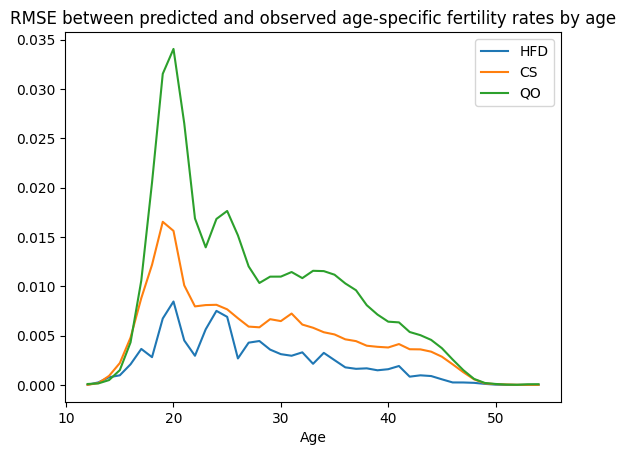

In [211]:
age_errors.plot()
#plt.ylabel('Error')
plt.xlabel('Age')
plt.title('RMSE between predicted and observed age-specific fertility rates by age')

Text(0.5, 1.0, 'Cumulative RMSE between predicted and observed age-specific fertility rates by age')

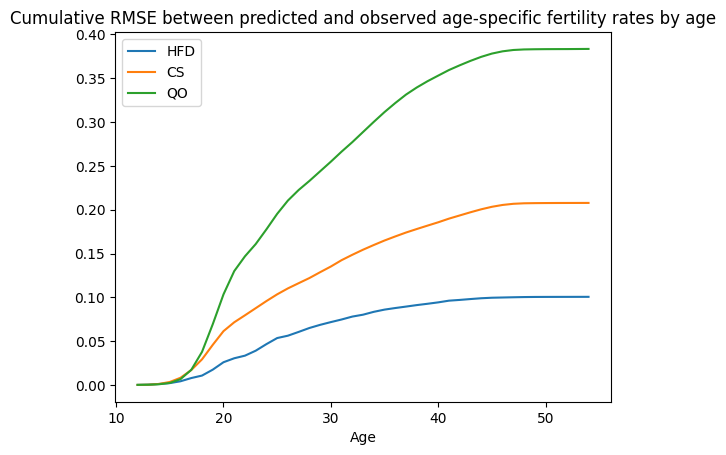

In [215]:
age_errors.cumsum().plot()
#plt.ylabel('Error')
plt.xlabel('Age')
plt.title('Cumulative RMSE between predicted and observed age-specific fertility rates by age')